In [1]:
from scapy.all import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
packets = rdpcap('./capture_3.pcapng')

In [3]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:           251G         18G        167G        2.9M         66G        231G
Swap:            0B          0B          0B


In [4]:
SCHEDULER = "192.168.1.116"
WORKER_1 = "192.168.1.117"
WORKER_2 = "192.168.1.118"
WORKER_3 = "192.168.1.115"

In [5]:
def get_src_ip(packet):
    return packet[IP].fields["src"]

def get_dst_ip(packet):
    return packet[IP].fields["dst"]

def get_time_size(packet):
    _time = packet.time
    _size = packet.payload.len
    return _time, _size

In [6]:
def plot_txrx(packets, ip_a):
    tx_log, rx_log = {}, {}

    for packet in packets:
        try:
            src_ip = get_src_ip(packet)
            if src_ip == ip_a:
                ts, size = get_time_size(packet)
                ts = str(int(ts))
                try:
                    tx_log[ts] += size
                except:
                    tx_log[ts] = 0
                    tx_log[ts] += size
        except:
            pass
        try:
            dst_ip = get_dst_ip(packet)
            if dst_ip == ip_a:
                ts, size = get_time_size(packet)
                ts = str(int(ts))
                try:
                    rx_log[ts] += size
                except:
                    rx_log[ts] = 0
                    rx_log[ts] += size
        except:
            pass

    tx_bw, rx_bw = [], []

    timeline = list(set(list(rx_log.keys()) + list(tx_log.keys())))
    timeline.sort()

    for time in timeline:
        try:
            rx_bw.append(8*rx_log[time]/1e6)
        except:
            pass
        try:
            tx_bw.append(8*tx_log[time]/1e6)
        except:
            pass

    timeline = [int(time) for time in timeline]
    timeline.sort()

    start_time = min(timeline)

    timeline = np.asarray(timeline) - start_time

    plt.plot(timeline, tx_bw, label="TX")
    plt.plot(timeline, rx_bw, label="RX")
    plt.legend()
    plt.title("Node Traffic ("+ip_a+")")
    plt.ylim(0, 1700)
    plt.ylabel("Traffic (Mbit)")
    plt.xlabel("Time")
    plt.show()

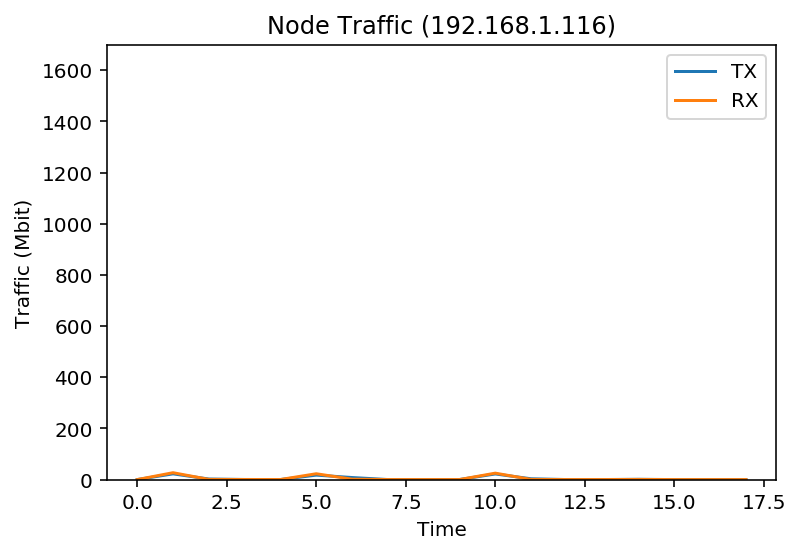

In [7]:
plot_txrx(packets, SCHEDULER)

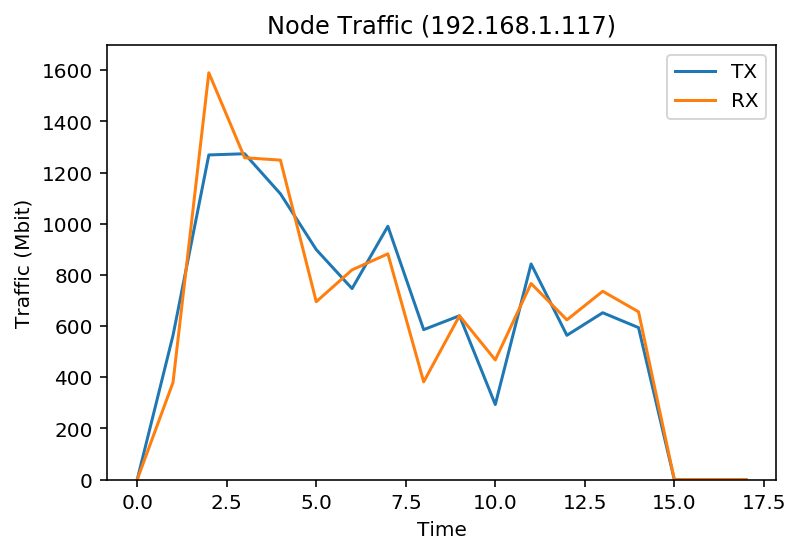

In [8]:
plot_txrx(packets, WORKER_1)

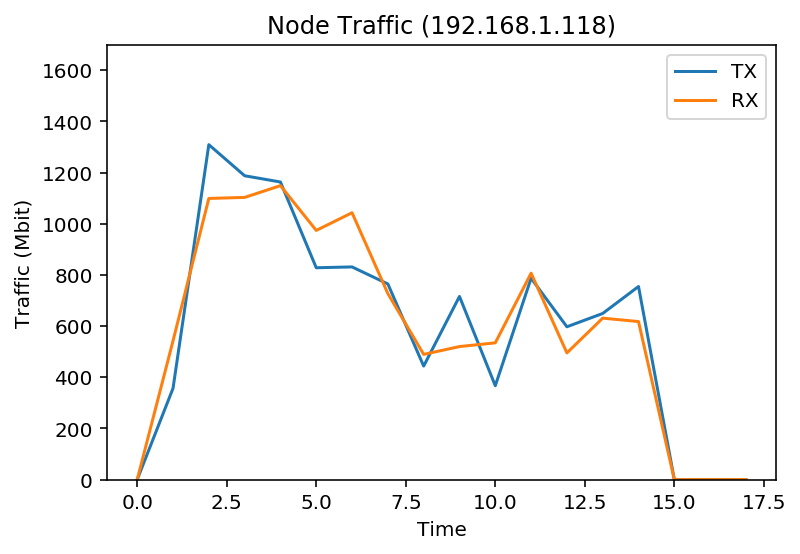

In [9]:
plot_txrx(packets, WORKER_2)

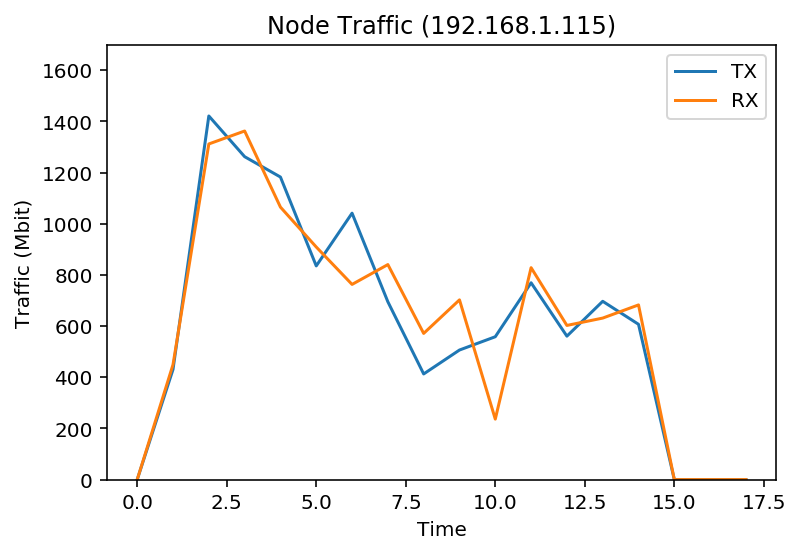

In [10]:
plot_txrx(packets, WORKER_3)

In [11]:
def total_traffic(packets, ip_a_1, ip_a_2):
    ip_1_to_2 = 0
    ip_2_to_1 = 0
    
    for packet in packets:
        try:
            src_ip = get_src_ip(packet)
            dst_ip = get_dst_ip(packet)
            if src_ip == ip_a_1 and dst_ip == ip_a_2:
                _, size = get_time_size(packet)
                ip_1_to_2 += size
        except:
            pass
        try:
            src_ip = get_src_ip(packet)
            dst_ip = get_dst_ip(packet)
            if src_ip == ip_a_2 and dst_ip == ip_a_1:
                _, size = get_time_size(packet)
                ip_2_to_1 += size
        except:
            pass
    
    return {
        "ip_1_to_2": ip_1_to_2,
        "ip_2_to_1": ip_2_to_1
    }

In [12]:
traffic = total_traffic(packets, SCHEDULER, WORKER_1)
print("Scheduler to worker:", round(traffic["ip_1_to_2"]/1e6, 1), "MBytes")
print("Worker to scheduler:", round(traffic["ip_2_to_1"]/1e6, 1), "MBytes")

Scheduler to worker: 3.2 MBytes
Worker to scheduler: 0.4 MBytes


In [13]:
traffic = total_traffic(packets, SCHEDULER, WORKER_2)
print("Scheduler to worker:", round(traffic["ip_1_to_2"]/1e6, 1), "MBytes")
print("Worker to scheduler:", round(traffic["ip_2_to_1"]/1e6, 1), "MBytes")

Scheduler to worker: 3.1 MBytes
Worker to scheduler: 0.4 MBytes


In [14]:
traffic = total_traffic(packets, SCHEDULER, WORKER_3)
print("Scheduler to worker:", round(traffic["ip_1_to_2"]/1e6, 1), "MBytes")
print("Worker to scheduler:", round(traffic["ip_2_to_1"]/1e6, 1), "MBytes")

Scheduler to worker: 3.3 MBytes
Worker to scheduler: 0.4 MBytes


In [15]:
traffic = total_traffic(packets, WORKER_1, WORKER_2)
print("Worker 1 to worker 2:", round(traffic["ip_1_to_2"]/1e6, 1), "MBytes")
print("Worker 2 to worker 1:", round(traffic["ip_2_to_1"]/1e6, 1), "MBytes")

Worker 1 to worker 2: 669.8 MBytes
Worker 2 to worker 1: 686.7 MBytes


In [16]:
traffic = total_traffic(packets, WORKER_1, WORKER_3)
print("Worker 1 to worker 2:", round(traffic["ip_1_to_2"]/1e6, 1), "MBytes")
print("Worker 2 to worker 1:", round(traffic["ip_2_to_1"]/1e6, 1), "MBytes")

Worker 1 to worker 2: 709.0 MBytes
Worker 2 to worker 1: 703.7 MBytes


In [17]:
traffic = total_traffic(packets, WORKER_2, WORKER_3)
print("Worker 1 to worker 2:", round(traffic["ip_1_to_2"]/1e6, 1), "MBytes")
print("Worker 2 to worker 1:", round(traffic["ip_2_to_1"]/1e6, 1), "MBytes")

Worker 1 to worker 2: 657.5 MBytes
Worker 2 to worker 1: 668.7 MBytes


In [95]:
def tx_breakdown(ip_a):
    other_ops = []
    type_counts  = {
        # dask worker heartbeat
        "heartbeat_worker": 0,
        # describes a compute task to worker
        "compute_task": 0,
        # reports task result to scheduler
        "task_finished": 0,
        # request for data
        "get_data": 0,
        # delete data (e.g. orphaned task)
        "delete_data": 0,
        # steal - distribute load at expense of data locality
        "steal_response": 0,
        "steal_request": 0,
        # register new data from external source
        "key_in_memory": 0,
        # others - binary data (no op)
        "others": 0,
    }

    for packet in packets:
        try:
            src_ip = get_src_ip(packet)
            if src_ip == ip_a:
                packet_type = None
                packet_load = packet.load.decode(errors="ignore")
                if "opheartbeat_worker" in packet_load:
                    packet_type = "heartbeat_worker"
                elif "optask-finished" in packet_load:
                    packet_type = "task_finished"
                elif "opget_data" in packet_load:
                    packet_type = "get_data"
                elif "opdelete-data" in packet_load:
                    packet_type = "delete_data"
                elif "opadd-keys" in packet_load:
                    packet_type = "add_keys"
                elif "opsteal-response" in packet_load:
                    packet_type = "steal_response"
                elif "opcompute-task" in packet_load:
                    packet_type = "compute_task"
                elif "opkey-in-memory" in packet_load:
                    packet_type = "key_in_memory"
                elif "opsteal-request" in packet_load:
                    packet_type = "steal_request"
                elif "\x00\x00op" in packet_load:
                    packet_type = "others"
                    other_ops.append(packet_load)
                else:
                    packet_type = "others"
                type_counts[packet_type] += 1
        except:
            pass
        
    return type_counts, other_ops

In [101]:
type_counts, other_ops = tx_breakdown(SCHEDULER)
type_counts

{'heartbeat_worker': 0,
 'compute_task': 1595,
 'task_finished': 0,
 'get_data': 6,
 'delete_data': 662,
 'steal_response': 0,
 'steal_request': 5,
 'key_in_memory': 6,
 'others': 1055}

In [102]:
sum(type_counts.values())

3329

In [103]:
type_counts, other_ops = tx_breakdown(WORKER_1)
type_counts

{'heartbeat_worker': 38,
 'compute_task': 0,
 'task_finished': 301,
 'get_data': 65,
 'delete_data': 0,
 'steal_response': 3,
 'steal_request': 0,
 'key_in_memory': 0,
 'others': 21991}

In [104]:
sum(type_counts.values())

22398

In [98]:
type_counts, other_ops = tx_breakdown(WORKER_2)
type_counts

{'heartbeat_worker': 42,
 'compute_task': 0,
 'task_finished': 315,
 'get_data': 78,
 'delete_data': 0,
 'steal_response': 1,
 'steal_request': 0,
 'key_in_memory': 0,
 'others': 21334}

In [99]:
type_counts, other_ops = tx_breakdown(WORKER_3)
type_counts

{'heartbeat_worker': 38,
 'compute_task': 0,
 'task_finished': 295,
 'get_data': 92,
 'delete_data': 0,
 'steal_response': 0,
 'steal_request': 0,
 'key_in_memory': 0,
 'others': 21695}